## Importing packages

In [51]:
# Basic packages
import os
import sys
import warnings
import cufflinks as cf
import numpy as np
import pandas as pd
from sklearn import set_config

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Data encoder packages
from sklearn.preprocessing import OneHotEncoder

# Missing data imputer packages
from sklearn.impute import KNNImputer

# Pipeline packages
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.pipeline import Pipeline

# Modelling packages
import scipy.stats as ss
from sklearn.linear_model import LogisticRegression
from statsmodels.formula.api import logit

# Model optimizer packages
from sklearn.model_selection import GridSearchCV

# Model metrics packages
from sklearn.metrics import (accuracy_score, roc_auc_score)

In [52]:
init_notebook_mode(connected=True)
%matplotlib inline
sns.set_style("dark")
plt.style.use("ggplot")
cf.go_offline()
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', '{:.2f}'.format)
set_config(display="diagram")

## Loading Data
Data source: World Bank. Philippines COVID-19 Households Survey (HFPS) 2020-2021. Ref: PHL_2020-2021_HFPS_v01_M <br>
Downloaded from https://microdata.worldbank.org/index.php/catalog/4480 on October 31, 2022 <br>
Survey dates: <br>
- Round 1: August 1, 2020 - August 14, 2020
- Round 2: December 10, 2020 - January 17, 2021
- Round 3: May 7, 2021 - June 11, 2021

In [53]:
df_r1 = pd.read_csv("data\WB_HH_survey_data_r1.csv")
df_r2 = pd.read_csv("data\WB_HH_survey_data_r2.csv")
df_r3 = pd.read_csv("data\WB_HH_survey_data_r3.csv")

In [54]:
df_r1_ncr = df_r1.query("prov == 39 or prov == 74 or prov == 75 or prov == 76").copy().reset_index(drop=True)
df_r2_ncr = df_r2.query("prov == 39 or prov == 74 or prov == 75 or prov == 76").copy().reset_index(drop=True)
df_r3_ncr = df_r3.query("prov == 39 or prov == 74 or prov == 75 or prov == 76").copy().reset_index(drop=True)

## Renaming columns

In [55]:
df_r1_ncr = df_r1_ncr[["Q2a", "Q2b", "Q2c", "Q4a",
                       "Q15", "Q16_1", "Q16_2", "Q16_3", "Q16_4", "Q16_5", "Q16_6", "Q17",
                       "Q23", "Q24a",
                       "Q31", "Q33", "Q35", "Q37"]]
df_r1_ncr.rename(
    columns={
    "Q2a": "sex", "Q2b": "age", "Q2c": "educ_att", "Q4a": "hh_size",
    "Q15": "trav_inc", "Q16_1": "walking", "Q16_2": "bicycle",
    "Q16_3": "pmt", "Q16_4": "bmj", "Q16_5": "tft",
        "Q16_6": "free_trans", "Q17": "reason_npu",
        "Q23": "acc_mt", "Q24a": "ct_avail",
        "Q31": "work_bm2", "Q33": "emp_status", "Q35": "sj_bc19",
        "Q37": "chg_income"}, inplace=True)

# df_r1_ncr.to_csv(r"C:\Users\User\Desktop\Files\Personal\Education\UP-SURP\Group Project\Plan 252A\Data\Discrete_Choice\r1_ncr_pre_data.csv")
df_r1_ncr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sex         3959 non-null   float64
 1   age         3937 non-null   float64
 2   educ_att    3981 non-null   float64
 3   hh_size     3983 non-null   int64  
 4   trav_inc    3473 non-null   float64
 5   walking     1977 non-null   float64
 6   bicycle     1977 non-null   float64
 7   pmt         1977 non-null   float64
 8   bmj         1977 non-null   float64
 9   tft         1977 non-null   float64
 10  free_trans  1977 non-null   float64
 11  reason_npu  1256 non-null   float64
 12  acc_mt      835 non-null    float64
 13  ct_avail    3374 non-null   float64
 14  work_bm2    3299 non-null   float64
 15  emp_status  3288 non-null   float64
 16  sj_bc19     1858 non-null   float64
 17  chg_income  1860 non-null   float64
dtypes: float64(17), int64(1)
memory usage: 560.2 KB


## Visualizing missing values

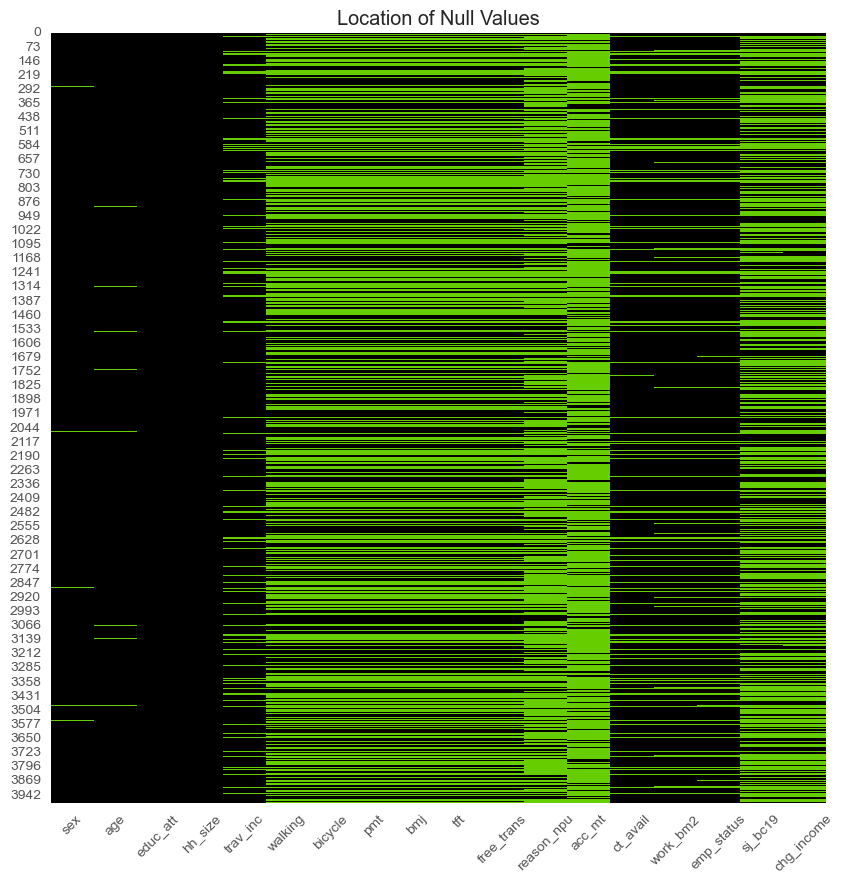

In [56]:
df_r1_ncr_na = df_r1_ncr.copy().reset_index(drop=True).isna()
fig_1, ax_1 = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax_1.set_title("Location of Null Values")
sns.heatmap(data=df_r1_ncr_na, ax=ax_1, cbar=False,
            cmap=sns.color_palette(["#000000", "#66CD00"]))
ax_1.tick_params(axis="x", rotation=45)

In [57]:
# na_array = []
# for column in df_r1_ncr.columns:
#     na_array.append(df_r1_ncr[column].isna().sum())
# df_r1_ncr_na = pd.DataFrame(
#     {
#         "null_values": na_array,
#         "column": df_r1_ncr.columns
#     }
# )
# df_r1_ncr_na = df_r1_ncr_na.sort_values(by="null_values", ascending=False).reset_index(drop=True)
# df_r1_ncr_na = df_r1_ncr_na.replace(columns=[])

In [58]:
df_r1_ncr.loc[(df_r1_ncr["work_bm2"] == 1) & (df_r1_ncr["emp_status"] == 2), "lost_job"] = 1
df_r1_ncr.loc[(df_r1_ncr["work_bm2"] == 2) & (df_r1_ncr["emp_status"] == 1), "lost_job"] = 0
df_r1_ncr.loc[(df_r1_ncr["work_bm2"] == 2) & (df_r1_ncr["emp_status"] == 2), "lost_job"] = 0
df_r1_ncr.loc[(df_r1_ncr["work_bm2"] == 1) & (df_r1_ncr["emp_status"] == 1), "lost_job"] = 0
# df_r1_ncr = df_r1_ncr.drop(columns=["trav_inc", "reason_npu", "work_bm2"])

In [59]:
for col in df_r1_ncr.columns:
    if col == "age":
        continue
    print(f"Value counts for {col}:")
    print(df_r1_ncr[col].value_counts(dropna=False).sort_index(), end= "\n\n")
    print("-------------------------------------------------------")

Value counts for sex:
sex
1.00    1506
2.00    2453
NaN       24
Name: count, dtype: int64

-------------------------------------------------------
Value counts for educ_att:
educ_att
1.00       1
2.00       1
3.00      17
4.00      25
5.00     132
6.00     394
7.00     219
8.00     839
9.00    2353
NaN        2
Name: count, dtype: int64

-------------------------------------------------------
Value counts for hh_size:
hh_size
1     165
2     439
3     655
4     818
5     706
6     432
7     298
8     190
9      94
10     73
11     41
12     21
13     11
14     14
15     10
16      3
17      3
18      1
20      3
24      1
25      5
Name: count, dtype: int64

-------------------------------------------------------
Value counts for trav_inc:
trav_inc
1.00    2026
2.00    1447
NaN      510
Name: count, dtype: int64

-------------------------------------------------------
Value counts for walking:
walking
0.00    1299
1.00     678
NaN     2006
Name: count, dtype: int64

------------------

In [60]:
df_r1_ncr.head()

,sex,age,educ_att,hh_size,trav_inc,walking,bicycle,pmt,bmj,tft,free_trans,reason_npu,acc_mt,ct_avail,work_bm2,emp_status,sj_bc19,chg_income,lost_job
0,1.00,32.00,9.00,2,1.00,1.00,0.00,0.00,0.00,0.00,0.00,5.00,NaN,1.00,1.00,1.00,1.00,2.00,0.00
1,2.00,50.00,9.00,7,1.00,0.00,0.00,0.00,0.00,1.00,0.00,NaN,2.00,1.00,1.00,1.00,1.00,2.00,0.00
2,2.00,49.00,9.00,5,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,NaN,2.00,2.00,2.00,NaN,NaN,0.00
3,2.00,33.00,9.00,2,1.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,1.00,1.00,1.00,1.00,1.00,3.00,0.00
4,2.00,27.00,8.00,4,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,2.00,1.00,1.00,1.00,3.00,0.00


## Pipeline for Encoding and Imputation

### Creating pipeline classes

#### Pipeline 1

In [61]:
class convert_code_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        b = x.copy()
        b.replace(
            {
                "sex": {1: 0, 2: 1},
                "educ_att": {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1},
                "acc_mt": {2: 0},
                "ct_avail": {2: 0, 3: -1},
                "work_bm2": {2: 0},
                "emp_status": {2: 0},
                "sj_bc19": {2: 0},
                "chg_income": {2: 0, 3: -1}
            }, inplace=True
        )
        return b

class binary_mode_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x.loc[(x["pmt"] == 1) & ((x["bmj"] == 0) & (x["tft"] == 0) & (x["free_trans"] == 0)), "mode"] = 0
        x.loc[(x["pmt"] == 0) & ((x["bmj"] == 0) & (x["tft"] == 0) & (x["free_trans"] == 0)), "mode"] = np.nan
        x.loc[(x["pmt"] == 1) & ((x["bmj"] == 1) | (x["tft"] == 1) | (x["free_trans"] == 1)), "mode"] = np.nan
        x.loc[(x["pmt"] == 0) & ((x["bmj"] == 1) | (x["tft"] == 1) | (x["free_trans"] == 1)), "mode"] = 1
        x.dropna(subset=["mode"], axis="index", inplace=True)
        x.drop(index=x.loc[x["acc_mt"] == 99].index, inplace=True)
        x.drop(index=x.loc[x["chg_income"] > 1].index, inplace=True)
        return x

class impute_na_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        impute_KNN = KNNImputer(n_neighbors=1)
        impute_KNN.fit(x[list(x.columns)])
        x[list(x.columns)] = impute_KNN.transform(x[list(x.columns)])
        return x 

class optimize_cols_1_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x["age"] = x["age"].apply(np.ceil)
        for col in x.columns:
            x[col] = x[col].astype(np.int32)
        return x
    
class drop_items_1_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x.drop(columns=["trav_inc", "walking", "pmt", "bmj", "tft", "free_trans", "reason_npu", 
                        "work_bm2"], inplace=True)
        return x

class ohe_encoding_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        ohe = OneHotEncoder()
        array = ohe.fit_transform(x[["ct_avail", "chg_income"]]).toarray()
        col_names_1 = list(ohe.get_feature_names_out())
        for i in range(len(array.T)):
            x[col_names_1[i]] = array.T[i]
        return x
    
class optimize_cols_2_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        for col in x.columns:
            x[col] = x[col].astype(np.int32)
        x = x.rename(columns={"educ_att": "higher_educ"})
        return x
    
class drop_items_2_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x.drop(columns=["ct_avail", "chg_income"], inplace=True)
        x.reset_index(drop=True, inplace=True)
        return x

#### Pipeline 2

In [62]:
class convert_code_2(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        b = x.copy()
        b.replace(
            {
                "sex": {1: 0, 2: 1},
                "educ_att": {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1},
                "acc_mt": {2: 0},
                "ct_avail": {2: 0, 3: -1},
                "work_bm2": {2: 0},
                "emp_status": {2: 0},
                "sj_bc19": {2: 0},
                "chg_income": {2: 0, 3: -1}
            }, inplace=True
        )
        return b

class binary_mode_2(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x.loc[(x["pmt"] == 1) & ((x["bmj"] == 0) & (x["tft"] == 0) & (x["free_trans"] == 0)), "mode"] = 0
        x.loc[(x["pmt"] == 0) & ((x["bmj"] == 0) & (x["tft"] == 0) & (x["free_trans"] == 0)), "mode"] = np.nan
        x.loc[(x["pmt"] == 1) & ((x["bmj"] == 1) | (x["tft"] == 1) | (x["free_trans"] == 1)), "mode"] = np.nan
        x.loc[(x["pmt"] == 0) & ((x["bmj"] == 1) | (x["tft"] == 1) | (x["free_trans"] == 1)), "mode"] = 1
        x.dropna(subset=["mode"], axis="index", inplace=True)
        x.drop(index=x.loc[x["acc_mt"] == 99].index, inplace=True)
        x.drop(index=x.loc[x["chg_income"] > 1].index, inplace=True)
        return x

class impute_na_2(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        impute_KNN = KNNImputer(n_neighbors=1)
        impute_KNN.fit(x[list(x.columns)])
        x[list(x.columns)] = impute_KNN.transform(x[list(x.columns)])
        return x 

class optimize_cols_1_2(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x["age"] = x["age"].apply(np.ceil)
        for col in x.columns:
            x[col] = x[col].astype(np.int32)
        x = x.rename(columns={"educ_att": "higher_educ"})
        return x
    
class drop_items_1_2(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x.drop(columns=["trav_inc", "walking", "pmt", "bmj", "tft", "free_trans", "reason_npu", 
                        "work_bm2"], inplace=True)
        return x

### Creating pipelines

#### Pipeline 1

In [63]:
pipe_1 = Pipeline(
    [
        ("convert", convert_code_1()),
        ("mode", binary_mode_1()),
        ("impute", impute_na_1()),
        ("optimize 1", optimize_cols_1_1()),
        ("drop 1", drop_items_1_1()),
        ("ohe", ohe_encoding_1()),
        ("optimize 2", optimize_cols_2_1()),
        ("drop 2", drop_items_2_1())
    ]
)

#### Pipeline 2

In [64]:
pipe_2 = Pipeline(
    [
        ("convert", convert_code_2()),
        ("mode", binary_mode_2()),
        ("impute", impute_na_2()),
        ("optimize 1", optimize_cols_1_2()),
        ("drop 1", drop_items_1_2())
    ]
)

### Application of pipelines into data

#### Pipeline 1

In [65]:
piped_df_1 = pipe_1.fit_transform(df_r1_ncr)

In [66]:
piped_df_1 = piped_df_1.rename(columns={"ct_avail_-1": "ct_avail_dk", "chg_income_-1": "chg_income_dec"})

In [67]:
piped_df_1.shape

(1493, 16)

In [68]:
df_y_1 = piped_df_1.copy()["mode"]
df_x_1 = piped_df_1.copy().drop(columns="mode").sort_index(axis="columns")
df_x_drp_1 = piped_df_1.copy().drop(columns=["ct_avail_0", "chg_income_0", "mode"]).sort_index(axis="columns")
piped_df_corr_1 = piped_df_1.copy().drop(columns=["ct_avail_0", "chg_income_0"]).sort_index(axis="columns")

In [69]:
for col in piped_df_1.columns:
    if col == "age":
        continue
    print(f"Value counts for {col}:")
    print(piped_df_1[col].value_counts(dropna=False).sort_index(), end= "\n\n")
    print("-------------------------------------------------------")

Value counts for sex:
sex
0    609
1    884
Name: count, dtype: int64

-------------------------------------------------------
Value counts for higher_educ:
higher_educ
0      20
1    1473
Name: count, dtype: int64

-------------------------------------------------------
Value counts for hh_size:
hh_size
1      67
2     191
3     225
4     312
5     260
6     159
7     104
8      71
9      40
10     28
11     13
12      6
13      2
14      4
15      4
16      2
17      1
18      1
20      2
25      1
Name: count, dtype: int64

-------------------------------------------------------
Value counts for bicycle:
bicycle
0    1414
1      79
Name: count, dtype: int64

-------------------------------------------------------
Value counts for acc_mt:
acc_mt
0     386
1    1107
Name: count, dtype: int64

-------------------------------------------------------
Value counts for emp_status:
emp_status
0    518
1    975
Name: count, dtype: int64

------------------------------------------------------

#### Pipeline 2

In [70]:
piped_df_2 = pipe_2.fit_transform(df_r1_ncr)

In [71]:
piped_df_2.shape

(1493, 12)

In [72]:
df_y_2 = piped_df_2.copy()["mode"]
df_x_2 = piped_df_2.copy().drop(columns="mode").sort_index(axis="columns")

In [73]:
for col in piped_df_2.columns:
    if col == "age":
        continue
    print(f"Value counts for {col}:")
    print(piped_df_2[col].value_counts(dropna=False).sort_index(), end= "\n\n")
    print("-------------------------------------------------------")

Value counts for sex:
sex
0    609
1    884
Name: count, dtype: int64

-------------------------------------------------------
Value counts for higher_educ:
higher_educ
0      20
1    1473
Name: count, dtype: int64

-------------------------------------------------------
Value counts for hh_size:
hh_size
1      67
2     191
3     225
4     312
5     260
6     159
7     104
8      71
9      40
10     28
11     13
12      6
13      2
14      4
15      4
16      2
17      1
18      1
20      2
25      1
Name: count, dtype: int64

-------------------------------------------------------
Value counts for bicycle:
bicycle
0    1414
1      79
Name: count, dtype: int64

-------------------------------------------------------
Value counts for acc_mt:
acc_mt
0     386
1    1107
Name: count, dtype: int64

-------------------------------------------------------
Value counts for ct_avail:
ct_avail
-1    490
 0    346
 1    657
Name: count, dtype: int64

----------------------------------------------

### Exploratory Data Analysis

In [74]:
fig_1 = go.Figure()

fig_1 = px.histogram(data_frame=piped_df_2, x="ct_avail", color="mode", color_discrete_map={-1:"#EEAEEE", 0: "#8DB6CD", 1: "#A2CD5A"},
                    barmode="group", title="Covid Test Availability and Mode", labels={"ct_avail": "Covid Test Availability"}, text_auto=True)
fig_1.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    plot_bgcolor="white", legend_title_text="Mode Type", legend_y=1.1,
    legend=dict(orientation="h"), bargroupgap=0.15, bargap=0.3, uniformtext_minsize=10)

fig_1.update_xaxes(ticklen=7, tickmode="array", ticktext=["Do Not Know", "Not Available", "Available"], tickvals=[-1, 0, 1])
fig_1.update_yaxes(ticklen=0, showticklabels=False, visible=False)

name_list_1=["Public", "Private"]
for i,trace in enumerate (fig_1.data):
  trace.update(name=name_list_1[i])

fig_1.update_traces(textposition="outside")

fig_1

In [75]:
fig_2 = go.Figure()

fig_2 = px.histogram(data_frame=piped_df_2, x="chg_income", color="mode", color_discrete_map={-1:"#EEAEEE", 0: "#8DB6CD", 1: "#A2CD5A"},
                    barmode="group", title="Change in Income and Mode", labels={"chg_income": "Change in Income"}, text_auto=True)
fig_2.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2), 
    plot_bgcolor="white", legend_title_text="Mode Type", legend_y=1.1,
    legend=dict(orientation="h"), bargroupgap=0.15, bargap=0.3, uniformtext_minsize=10)

fig_2.update_xaxes(ticklen=7, tickmode="array", ticktext=["Decrease", "Remain the Same", "Increase"], tickvals=[-1, 0, 1])
fig_2.update_yaxes(ticklen=0, showticklabels=False, visible=False)

name_list_1=["Public", "Private"]
for i,trace in enumerate (fig_2.data):
  trace.update(name=name_list_1[i])

fig_2.update_traces(textposition="outside")

fig_2

#### Visualizing correlation between variables

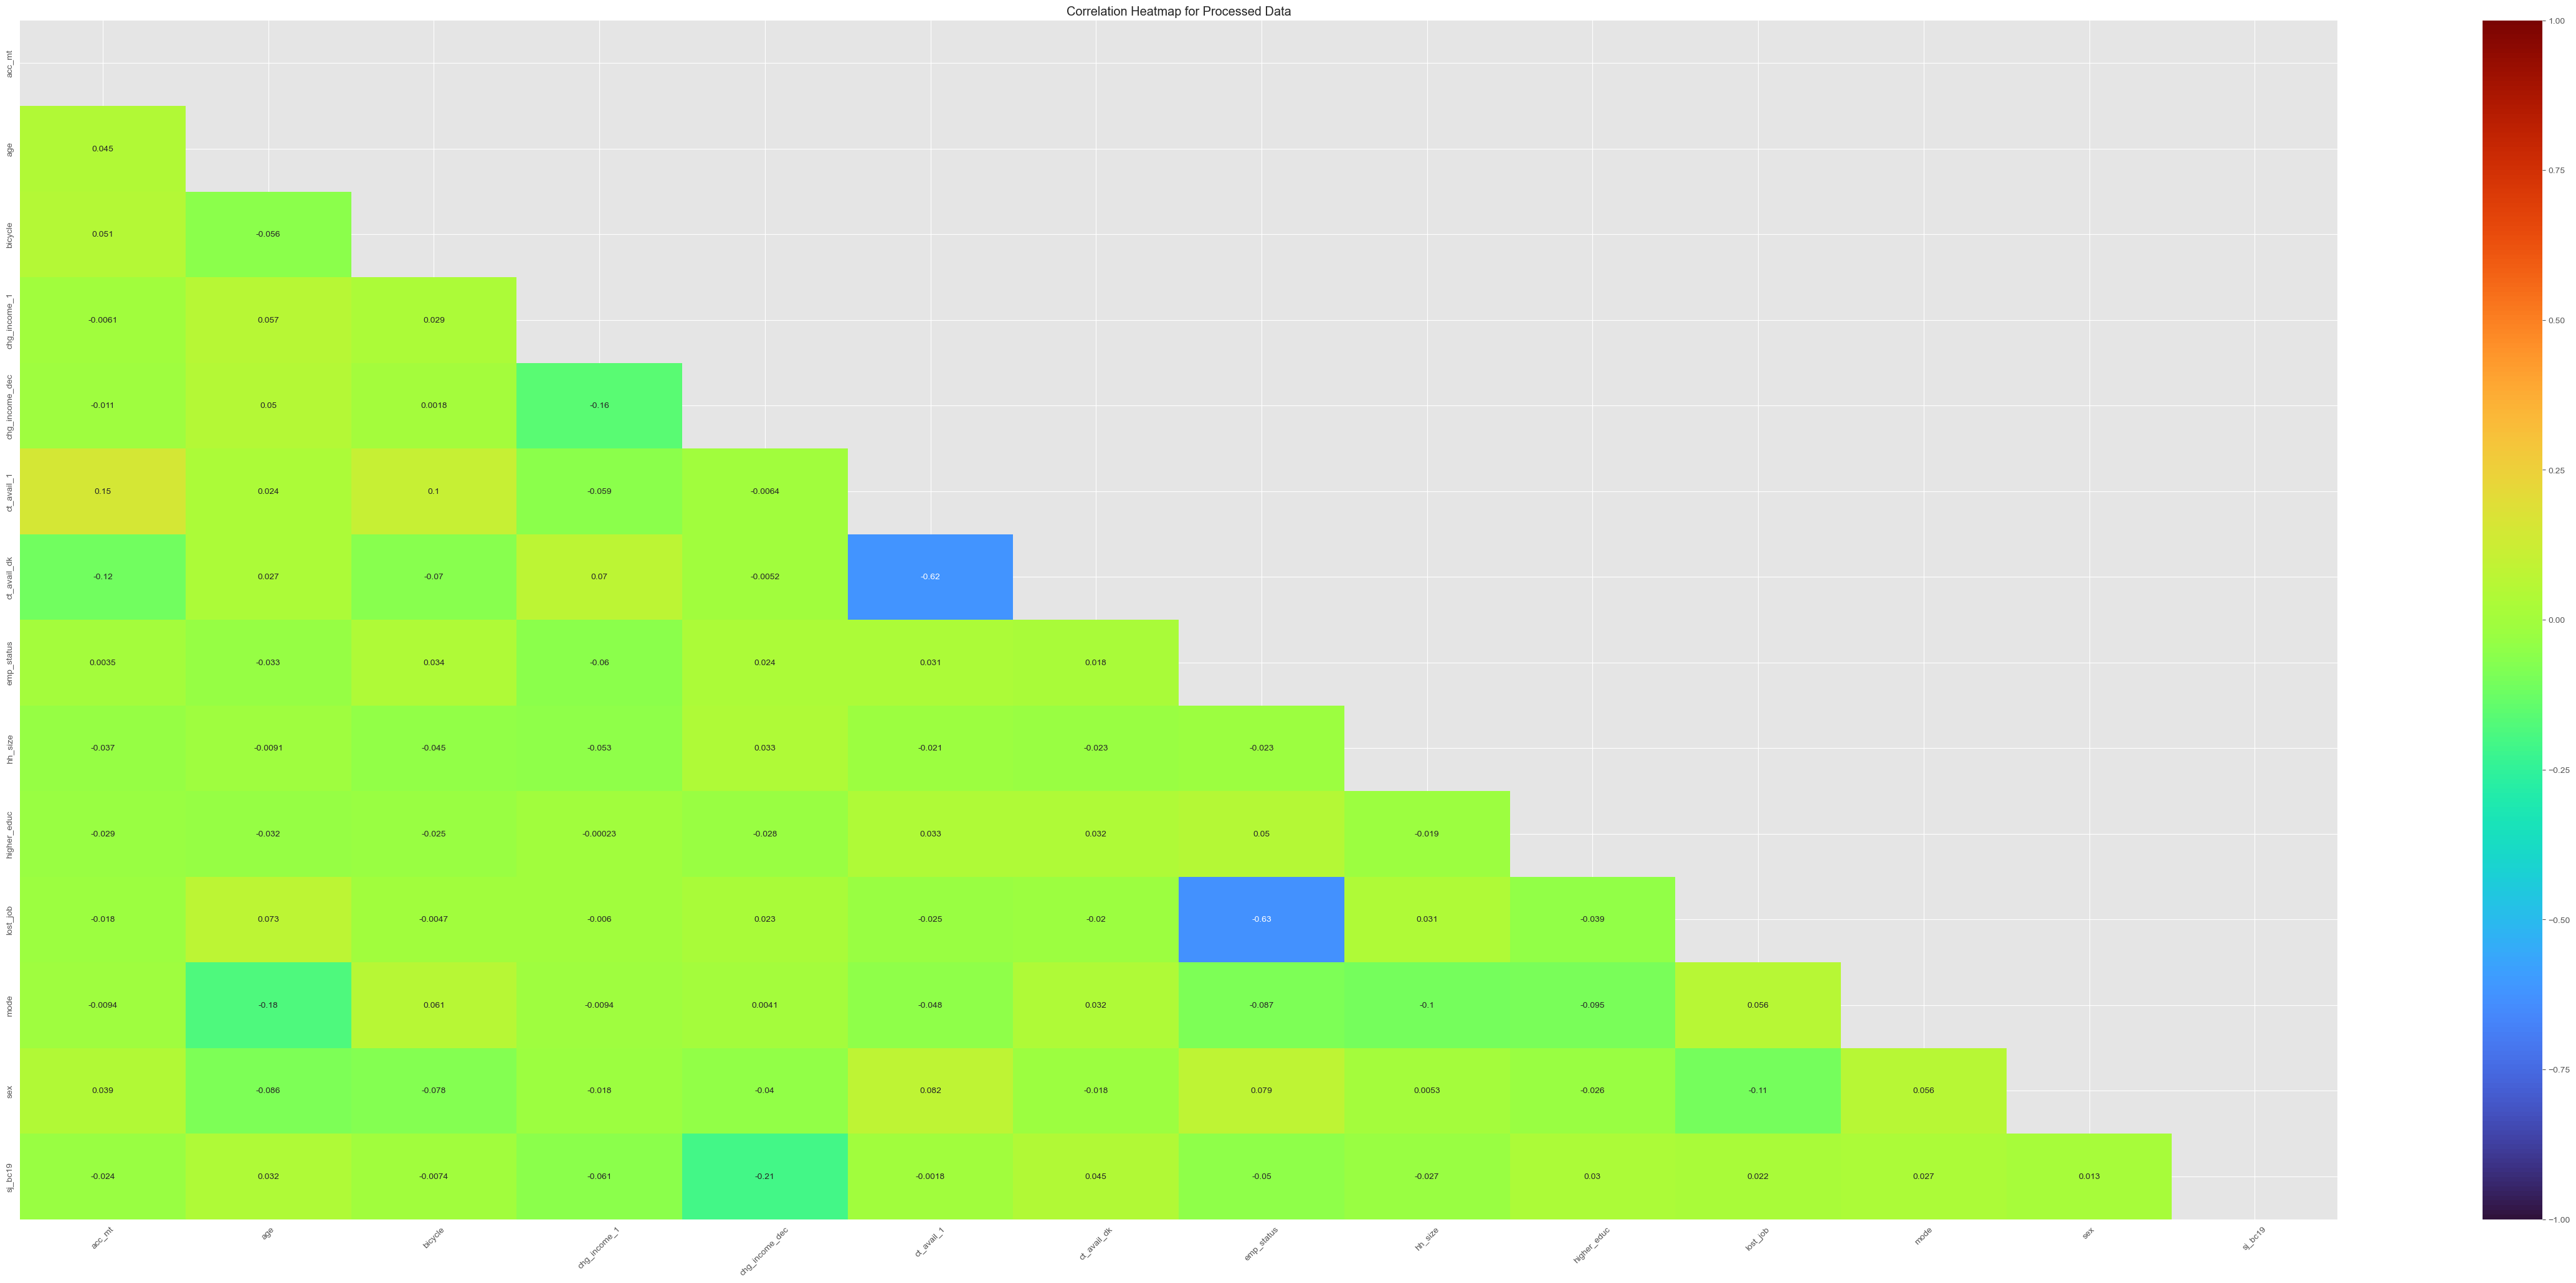

In [76]:
corr_piped_1 = piped_df_corr_1.corr(method="spearman")
corr_mask_piped_1 = np.triu(np.ones_like(corr_piped_1))

fig_3, ax_3 = plt.subplots(nrows=1, ncols=1, figsize=(60,25))
sns.heatmap(corr_piped_1, ax=ax_3, cmap="turbo", annot=True, vmin=-1, vmax=1, mask=corr_mask_piped_1)
ax_3.set_title("Correlation Heatmap for Processed Data")
ax_3.tick_params(axis="x", rotation=45)

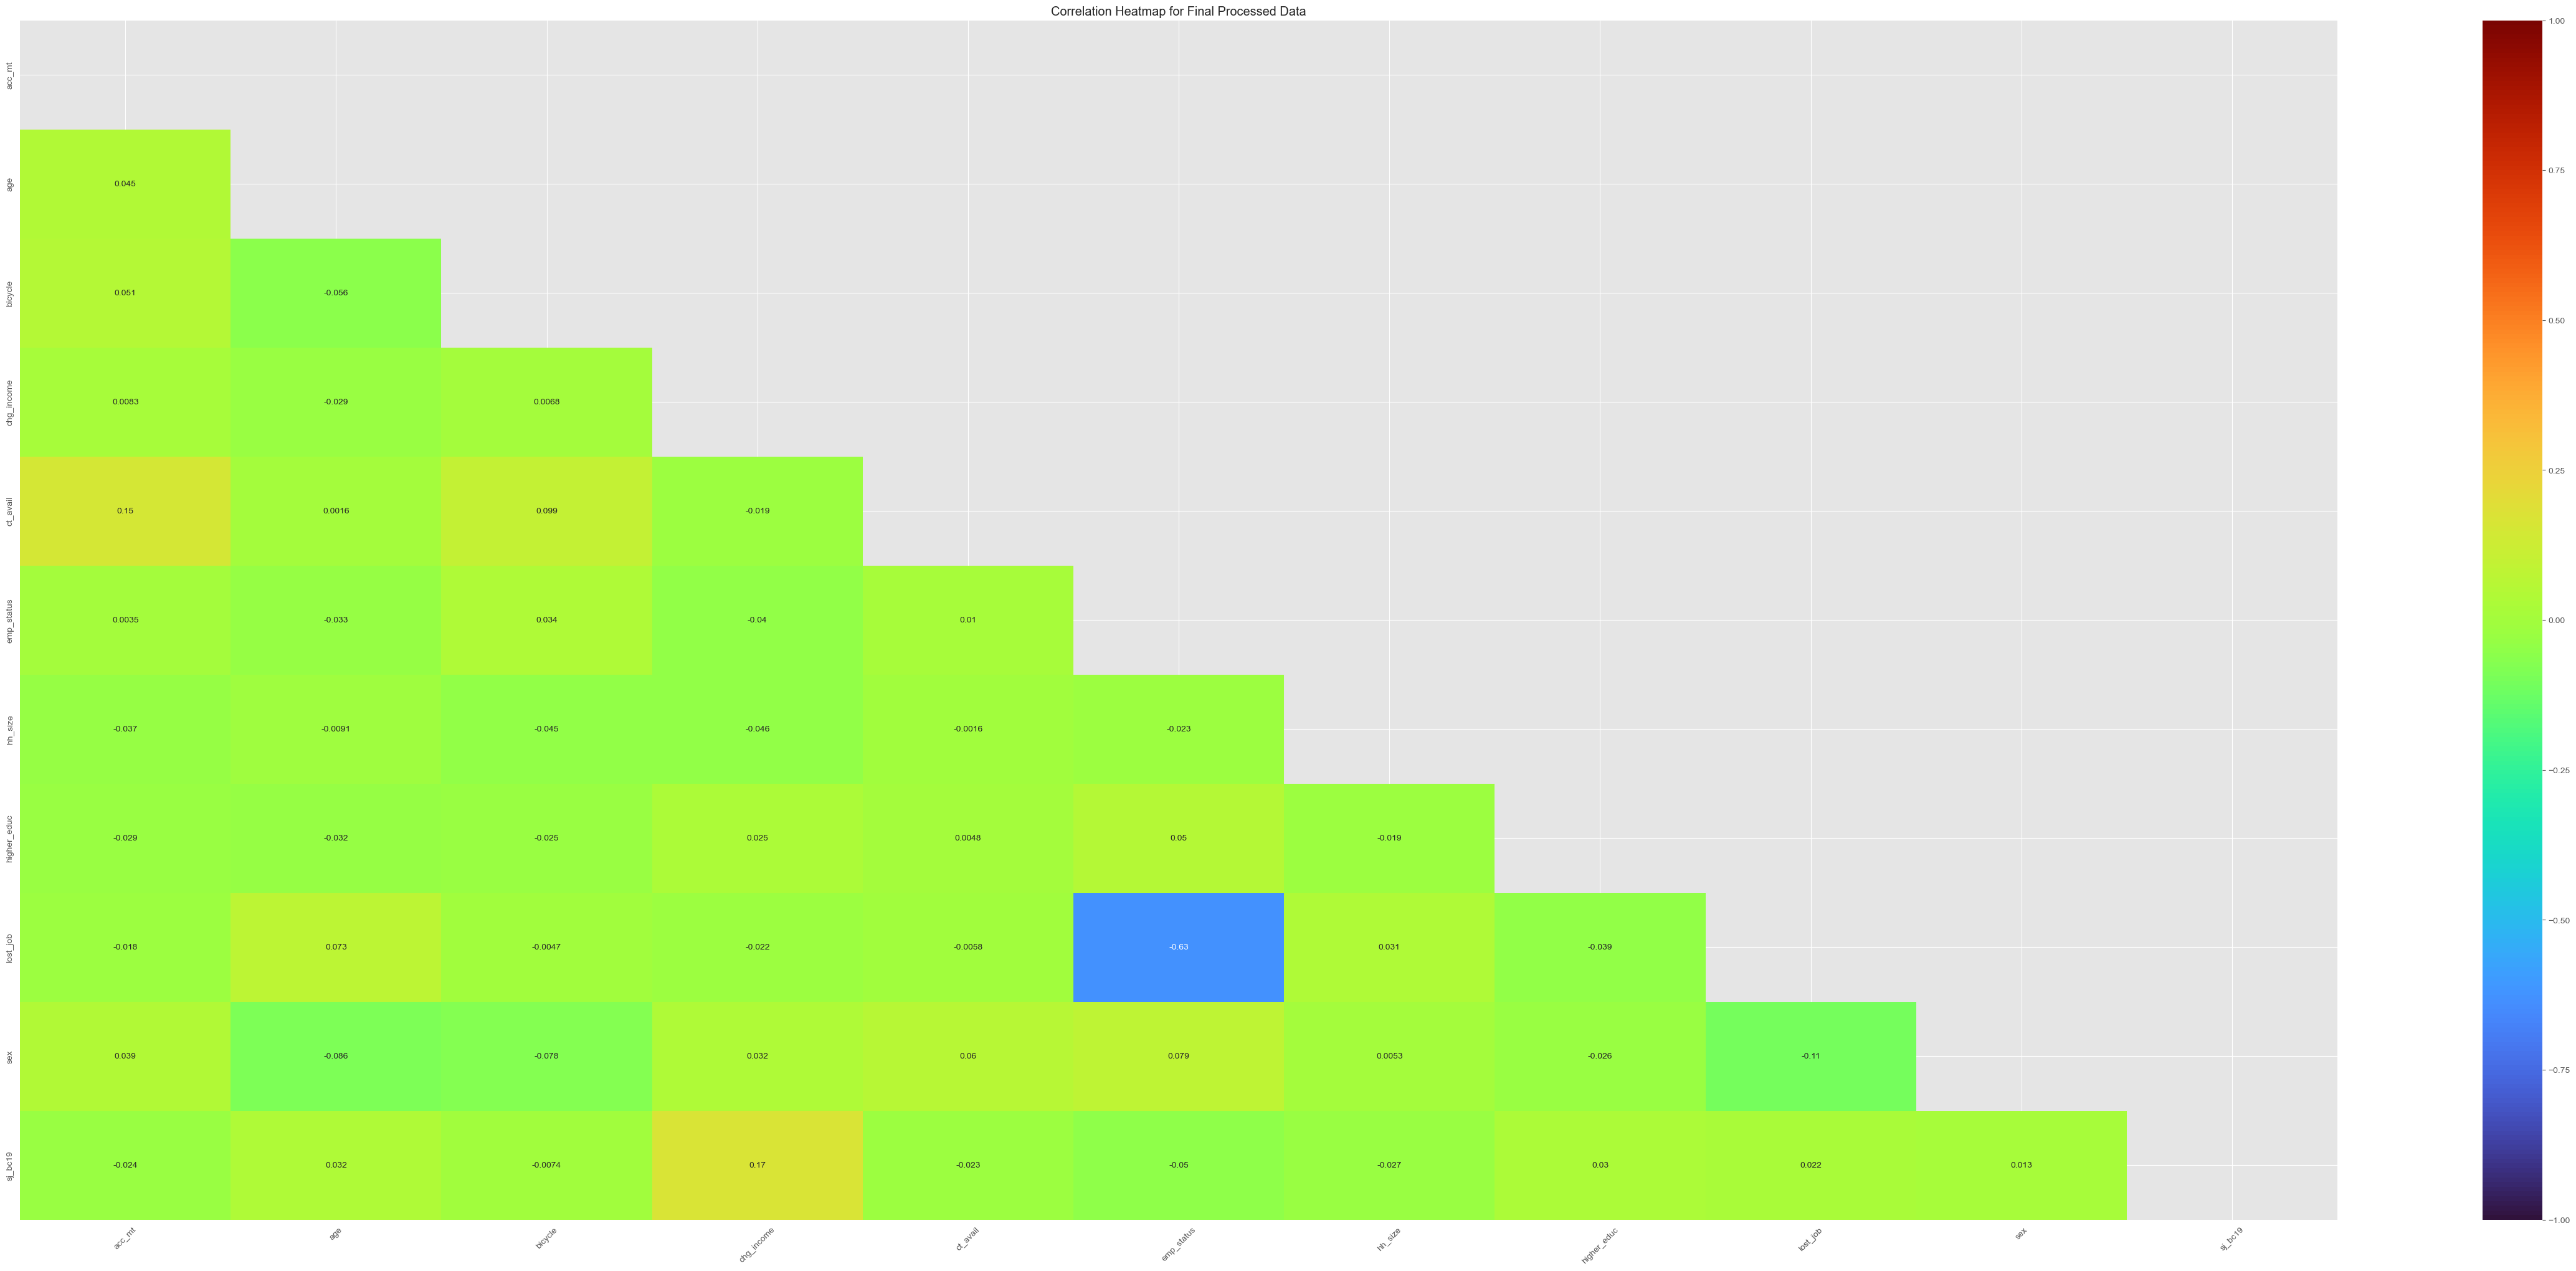

In [77]:
corr_piped_2 = df_x_2.corr(method="spearman")
corr_mask_piped_2 = np.triu(np.ones_like(corr_piped_2))

fig_4, ax_4 = plt.subplots(nrows=1, ncols=1, figsize=(60,25))
sns.heatmap(corr_piped_2, ax=ax_4, cmap="turbo", annot=True, vmin=-1, vmax=1, mask=corr_mask_piped_2)
ax_4.set_title("Correlation Heatmap for Final Processed Data")
ax_4.tick_params(axis="x", rotation=45)

### Saving processed dataframe into csv file

In [78]:
# piped_df_1.to_csv(r"C:\Users\User\Desktop\Files\Personal\Education\UP-SURP\Group Project\Plan 252A\Data\Discrete_Choice\r1_ncr_post_data_distinct_binary_revised_1.csv")
# piped_df_2.to_csv(r"C:\Users\User\Desktop\Files\Personal\Education\UP-SURP\Group Project\Plan 252A\Data\Discrete_Choice\r1_ncr_post_data_distinct_binary_revised_2.csv")

## Modeling using Logistic Regression

### Model 1

#### Hyperparameter tuning

In [79]:
params_logreg_GS_1 = {"solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
logreg_GS_1 = LogisticRegression(random_state=252)
GS_logreg_1 = GridSearchCV(
    estimator=logreg_GS_1,
    cv=5,
    param_grid=params_logreg_GS_1,
    scoring="accuracy",
    refit="accuracy",
    verbose=4
)

#### Application of hypterparameter tuning

In [80]:
GS_logreg_1.fit(df_x_drp_1, df_y_1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..................solver=newton-cg;, score=0.652 total time=   0.0s
[CV 2/5] END ..................solver=newton-cg;, score=0.666 total time=   0.0s
[CV 3/5] END ..................solver=newton-cg;, score=0.682 total time=   0.0s
[CV 4/5] END ..................solver=newton-cg;, score=0.604 total time=   0.0s
[CV 5/5] END ..................solver=newton-cg;, score=0.634 total time=   0.0s
[CV 1/5] END ......................solver=lbfgs;, score=0.652 total time=   0.0s
[CV 2/5] END ......................solver=lbfgs;, score=0.659 total time=   0.0s
[CV 3/5] END ......................solver=lbfgs;, score=0.686 total time=   0.0s
[CV 4/5] END ......................solver=lbfgs;, score=0.601 total time=   0.0s
[CV 5/5] END ......................solver=lbfgs;, score=0.634 total time=   0.0s
[CV 1/5] END ..................solver=liblinear;, score=0.649 total time=   0.0s
[CV 2/5] END ..................solver=liblinear;,

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=252),
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             refit='accuracy', scoring='accuracy', verbose=4)

In [81]:
acc_GS_logreg_1 = round(GS_logreg_1.best_score_*100, 2)
solver_GS_logreg_1 = GS_logreg_1.best_params_["solver"]
print(f"Best parameter for Logistic Regression is a solver of {solver_GS_logreg_1} arriving at an average CV accuracy of {acc_GS_logreg_1}%")

Best parameter for Logistic Regression is a solver of newton-cg arriving at an average CV accuracy of 64.77%


#### Modeling Logistic Regression

In [82]:
best_logreg_1 = LogisticRegression(solver="lbfgs")
best_logreg_1.fit(df_x_drp_1, df_y_1)
predict_proba_1 = best_logreg_1.predict_proba(df_x_drp_1)
int_best_logreg_1 = best_logreg_1.intercept_[0]
best_logreg_index_1 = ["intercept"]
for col in best_logreg_1.feature_names_in_:
    best_logreg_index_1.append(col)
coeff_logreg_1 = pd.DataFrame({"Coefficient": best_logreg_1.coef_[0]}, index=df_x_drp_1.columns)
print("Resulting Coefficient for Logistic Regression")
print(coeff_logreg_1.sort_index(axis="index", ascending=True))
print(f"intercept:             {round(int_best_logreg_1, 4)}")

Resulting Coefficient for Logistic Regression
                Coefficient
acc_mt                -0.02
age                   -0.04
bicycle                0.50
chg_income_1          -0.04
chg_income_dec         0.08
ct_avail_1            -0.16
ct_avail_dk            0.10
emp_status            -0.41
hh_size               -0.09
higher_educ           -1.41
lost_job               0.11
sex                    0.24
sj_bc19                0.20
intercept:             2.5233


#### Model 1 results

In [83]:
logit_4_1 = logit("mode ~ sex + age + higher_educ + bicycle + acc_mt + emp_status \
                + sj_bc19 + lost_job + ct_avail_dk + ct_avail_1 + chg_income_dec \
                + chg_income_1", data=piped_df_1).fit()

Optimization terminated successfully.
         Current function value: 0.620014
         Iterations 5


In [84]:
logit_4_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   mode   No. Observations:                 1493
Model:                          Logit   Df Residuals:                     1480
Method:                           MLE   Df Model:                           12
Date:                Tue, 03 Sep 2024   Pseudo R-squ.:                 0.04915
Time:                        09:45:15   Log-Likelihood:                -925.68
converged:                       True   LL-Null:                       -973.53
Covariance Type:            nonrobust   LLR p-value:                 3.844e-15
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.3867      0.623      3.833      0.000       1.166       3.607
sex                0.2412      0.117      2.068      0.039       0.013       0.470
age               -0.0370      0.005     -7.055      0.000      -0.047      -0.027
higher_educ       -1.7930      0.537     -3.338      0.001      -2.846      -0.740
bicycle            0.5592      0.244      2.289      0.022       0.080       1.038
acc_mt             0.0048      0.129      0.037      0.970      -0.248       0.257
emp_status        -0.3942      0.149     -2.648      0.008      -0.686      -0.102
sj_bc19            0.2477      0.183      1.351      0.177      -0.112       0.607
lost_job           0.1024      0.186      0.549      0.583      -0.263       0.468
ct_avail_dk        0.1221      0.151      0.808      0.419      -0.174       0.418
ct_avail_1        -0.1471      0.146     -1.008      0.313      -0.433       0.139
chg_income_dec     0.0897      0.123      0.731      0.465      -0.151       0.330
chg_income_1       0.0184      0.271      0.068      0.946      -0.512       0.549
==================================================================================
"""

### Model 2

#### Hyperparameter tuning

In [85]:
params_logreg_GS_2 = {"solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
logreg_GS_2 = LogisticRegression(random_state=252)
GS_logreg_2 = GridSearchCV(
    estimator=logreg_GS_2,
    cv=5,
    param_grid=params_logreg_GS_2,
    scoring="accuracy",
    refit="accuracy",
    verbose=4
)

#### Application of hypterparameter tuning

In [86]:
GS_logreg_2.fit(df_x_2, df_y_2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..................solver=newton-cg;, score=0.652 total time=   0.0s
[CV 2/5] END ..................solver=newton-cg;, score=0.666 total time=   0.0s
[CV 3/5] END ..................solver=newton-cg;, score=0.682 total time=   0.0s


[CV 4/5] END ..................solver=newton-cg;, score=0.611 total time=   0.0s
[CV 5/5] END ..................solver=newton-cg;, score=0.648 total time=   0.0s
[CV 1/5] END ......................solver=lbfgs;, score=0.649 total time=   0.0s
[CV 2/5] END ......................solver=lbfgs;, score=0.666 total time=   0.0s
[CV 3/5] END ......................solver=lbfgs;, score=0.686 total time=   0.0s
[CV 4/5] END ......................solver=lbfgs;, score=0.607 total time=   0.0s
[CV 5/5] END ......................solver=lbfgs;, score=0.648 total time=   0.0s
[CV 1/5] END ..................solver=liblinear;, score=0.662 total time=   0.0s
[CV 2/5] END ..................solver=liblinear;, score=0.669 total time=   0.0s
[CV 3/5] END ..................solver=liblinear;, score=0.682 total time=   0.0s
[CV 4/5] END ..................solver=liblinear;, score=0.604 total time=   0.0s
[CV 5/5] END ..................solver=liblinear;, score=0.638 total time=   0.0s
[CV 1/5] END ...............

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=252),
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             refit='accuracy', scoring='accuracy', verbose=4)

In [87]:
acc_GS_logreg_2 = round(GS_logreg_2.best_score_*100, 2)
solver_GS_logreg_2 = GS_logreg_2.best_params_["solver"]
print(f"Best parameter for Logistic Regression is a solver of {solver_GS_logreg_2} arriving at an average CV accuracy of {acc_GS_logreg_2}%")

Best parameter for Logistic Regression is a solver of newton-cg arriving at an average CV accuracy of 65.17%


#### Modeling Logistic Regression

In [88]:
best_logreg_2 = LogisticRegression(solver="newton-cg")
best_logreg_2.fit(df_x_2, df_y_2)
predict_proba_2 = best_logreg_2.predict_proba(df_x_2)
int_best_logreg_2 = best_logreg_2.intercept_[0]
best_logreg_index_2 = ["intercept"]
for col in best_logreg_2.feature_names_in_:
    best_logreg_index_2.append(col)
coeff_logreg_2 = pd.DataFrame({"Coefficient": best_logreg_2.coef_[0]}, index=df_x_2.columns)
print("Resulting Coefficient for Logistic Regression")
print(coeff_logreg_2.sort_index(axis="index", ascending=True))
print(f"intercept:          {round(int_best_logreg_2, 4)}")

Resulting Coefficient for Logistic Regression
             Coefficient
acc_mt             -0.01
age                -0.04
bicycle             0.49
chg_income         -0.07
ct_avail           -0.14
emp_status         -0.41
hh_size            -0.09
higher_educ        -1.45
lost_job            0.11
sex                 0.24
sj_bc19             0.20
intercept:          2.5421


#### Model 2 results

In [89]:
logit_4_2 = logit("mode ~ sex + age + higher_educ + bicycle + acc_mt + emp_status \
                + sj_bc19 + lost_job + ct_avail + chg_income", data=piped_df_2).fit()

Optimization terminated successfully.
         Current function value: 0.620055
         Iterations 5


In [90]:
logit_4_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   mode   No. Observations:                 1493
Model:                          Logit   Df Residuals:                     1482
Method:                           MLE   Df Model:                           10
Date:                Tue, 03 Sep 2024   Pseudo R-squ.:                 0.04909
Time:                        09:45:16   Log-Likelihood:                -925.74
converged:                       True   LL-Null:                       -973.53
Covariance Type:            nonrobust   LLR p-value:                 4.158e-16
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.4018      0.620      3.875      0.000       1.187       3.617
sex             0.2403      0.116      2.066      0.039       0.012       0.468
age            -0.0369      0.005     -7.072      0.000      -0.047      -0.027
higher_educ    -1.7970      0.535     -3.357      0.001      -2.846      -0.748
bicycle         0.5619      0.244      2.304      0.021       0.084       1.040
acc_mt          0.0033      0.129      0.026      0.980      -0.249       0.255
emp_status     -0.3973      0.149     -2.674      0.008      -0.689      -0.106
sj_bc19         0.2364      0.181      1.309      0.191      -0.118       0.590
lost_job        0.1005      0.186      0.540      0.589      -0.265       0.466
ct_avail       -0.1365      0.065     -2.089      0.037      -0.265      -0.008
chg_income     -0.0673      0.104     -0.649      0.516      -0.270       0.136
===============================================================================
"""